In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import csv
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("whitegrid")
from datetime import datetime, date
from os import path
import os
import sys

import keras
from keras.callbacks import EarlyStopping
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

# Any results you write to the current directory are saved as output.

Using TensorFlow backend.
/Users/juan/anaconda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


## loading data

In [8]:
data_path='data/temporal'

In [9]:
X = np.load(path.join(data_path,'X.npy'))
X.shape

(109490, 531)

In [25]:
y = np.load(path.join(data_path,'y.npy'))
y.shape

(109490,)

In [27]:
# import src.lib.balance_data as bl
# X, y = bl.balance_data(X,y)

In [28]:
#split data into train and test dataset (80%/20%)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=421)
print('X_train num',X_train.shape[0])
print('X_test num',X_test.shape[0])

X_train num 98541
X_test num 10949


In [30]:
# # Import `StandardScaler` from `sklearn.preprocessing`
from sklearn.preprocessing import MinMaxScaler,StandardScaler #StandardScaler
#Define the scaler 
# # scaler = MinMaxScaler(feature_range=(-1, 1))
# scaler = StandardScaler().fit(X_train)
# # Scale the train set
# X_train = scaler.transform(X_train)
# # Scale the test set
# X_test = scaler.transform(X_test)

In [31]:
time_feature_beg=13  # temporal feature start position
X_train_time = X_train[:,time_feature_beg:]
X_test_time = X_test[:,time_feature_beg:]
X_train_aux = X_train[:,0:time_feature_beg]
X_test_aux = X_test[:,0:time_feature_beg]
print(X_train_time.shape)
print(X_test_time.shape)
print(X_train_aux.shape)
print(X_test_aux.shape)

(98541, 518)
(10949, 518)
(98541, 13)
(10949, 13)


In [32]:
def case_contro_ratio(y):
    num_of_case = y[y==1].shape[0]
    num_of_control = y[y==0].shape[0]
    ratio = num_of_control/num_of_case
    return ratio, num_of_case, num_of_control

In [33]:
print('train ratio %.2f, case %d, control %d ' % (case_contro_ratio(y_train)[0], case_contro_ratio(y_train)[1],case_contro_ratio(y_train)[2]))
# print('valid cohort ratio %.2f, case %d, control %d'% (case_contro_ratio(y_valid)[0], case_contro_ratio(y_valid)[1],case_contro_ratio(y_valid)[2]))
print('test cohort ratio %.2f case %d, control %d' % (case_contro_ratio(y_test)[0],case_contro_ratio(y_test)[1],case_contro_ratio(y_test)[2]))

train ratio 10.16, case 8830, control 89711 
test cohort ratio 10.02 case 994, control 9955


In [34]:
# reshape the temporal features
def reshape_time_series(X, time_steps, feature_size):
     """
    :param X: Input features
    :param time_steps: time intervals, or number of windows (e.g. 7 years in our data )
    :param feature_size: size of distinct feature
    :return:reshaped features
    """
        
    X_new = np.zeros(shape=(X.shape[0],X.shape[1]))
    idx=0
    for i in range(time_steps):
        for j in range(feature_size):
            X_new[:,idx] = X[:,i+j*time_steps]
            idx+=1
    return X_new

In [35]:

X_train_time_new = reshape_time_series(X_train_time,time_steps=7,feature_size=74) #74 distinct features
X_train_time_new.shape

(98541, 518)

In [36]:
# X_test_time_new = reshape_time_series(X_test_time,7,14)
X_test_time_new = reshape_time_series(X_test_time,7,74)
X_test_time_new.shape

(10949, 518)

In [37]:
feature_list = [str(i) for i in range(2000,2006)] # years
feature_list

['2000', '2001', '2002', '2003', '2004', '2005']

## standarscale the data

In [38]:
# reshape input to be 3D [samples, timesteps, features]
timesteps=7
X_train_time = X_train_time_new.reshape((X_train_time_new.shape[0], timesteps, int(X_train_time_new.shape[1]/timesteps)))
X_test_time = X_test_time_new.reshape((X_test_time_new.shape[0], timesteps, int(X_test_time_new.shape[1]/timesteps)))
print(X_train_time.shape)
print(X_test_time.shape)

(98541, 7, 74)
(10949, 7, 74)


In [39]:
X_train_time.iloc

array([[[119. , 146. , 119. , ...,   0. ,   0. ,   0. ],
        [119. , 146. , 119. , ...,   0. ,   0. ,   0. ],
        [119. , 146. , 119. , ...,   0. ,   0. ,   0. ],
        ...,
        [119. , 146. , 119. , ...,   0. ,   0. ,   0. ],
        [119. , 146. , 119. , ...,   0. ,   0. ,   0. ],
        [119. , 146. ,  86. , ...,   0. ,   0. ,   0. ]],

       [[ 90. , 136. ,  90. , ...,   0. ,   0. ,   0. ],
        [ 90. , 136. ,  90. , ...,   0. ,   0. ,   0. ],
        [ 90. , 136. ,  90. , ...,   0. ,   0. ,   0. ],
        ...,
        [ 90. , 136. ,  90. , ...,   0. ,   0. ,   0. ],
        [ 90. , 140. ,  85. , ...,   0. ,   0. ,   0. ],
        [ 94. , 142. ,  94. , ...,   0. ,   0. ,   0. ]],

       [[ 68. , 108. ,  68. , ...,   0. ,   0. ,   0. ],
        [ 68. , 108. ,  68. , ...,   0. ,   0. ,   0. ],
        [ 68. , 108. ,  68. , ...,   0. ,   0. ,   0. ],
        ...,
        [ 84. , 122. ,  75. , ...,   0. ,   0. ,   0. ],
        [ 66. ,  98. ,  66. , ...,   0. ,   0

In [24]:
# Import `Sequential` from `keras.models`
from keras.models import Sequential
# Import `Dense` from `keras.layers`
from keras.layers import Dense, Dropout
from keras.layers import LSTM
from keras.layers import Input
from keras.models import Model
import keras

In [25]:
main_input = Input(shape=(X_train_time.shape[1], X_train_time.shape[2]), name='main_input')
lstm_out = LSTM(84, dropout=0.1, recurrent_dropout=0.1)(main_input)

# lstm_out = LSTM(84)(main_input)
auxiliary_output = Dense(1, activation='sigmoid', name='aux_output')(lstm_out)

auxiliary_input = Input(shape=(time_feature_beg,), name='aux_input')
x = keras.layers.concatenate([lstm_out, auxiliary_input])

# We stack a deep densely-connected network on top
x = Dense(8, activation='relu')(x)
x= Dropout(0.1)(x)
x = Dense(8, activation='relu')(x)
x= Dropout(0.1)(x)


# And finally we add the main logistic regression layer
main_output = Dense(1, activation='sigmoid', name='main_output')(x)
#This defines a model with two inputs and two outputs:
model = Model(inputs=[main_input, auxiliary_input], outputs=[main_output, auxiliary_output])

In [26]:
# Model output shape
model.output_shape
# Model summary
model.summary()
# Model config
model.get_config()
# List all weight tensors 
model.get_weights()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 7, 74)        0                                            
__________________________________________________________________________________________________
lstm_1 (LSTM)                   (None, 84)           53424       main_input[0][0]                 
__________________________________________________________________________________________________
aux_input (InputLayer)          (None, 13)           0                                            
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 97)           0           lstm_1[0][0]                     
                                                                 aux_input[0][0]                  
__________

[array([[ 0.07439198, -0.01115449, -0.03859836, ..., -0.06209642,
         -0.04029816,  0.03973766],
        [ 0.02970695, -0.03725597, -0.04815671, ...,  0.02228572,
         -0.07461698, -0.08958131],
        [-0.00820258,  0.09913025, -0.04388729, ..., -0.11732537,
         -0.04989307,  0.08130426],
        ..., 
        [ 0.10048299,  0.09385218,  0.08753134, ..., -0.08879401,
          0.04840863,  0.10997284],
        [ 0.05333755, -0.04175213,  0.01096482, ..., -0.01815384,
          0.0977878 ,  0.03929863],
        [-0.08718094,  0.05484312,  0.00038746, ...,  0.04861846,
          0.00084905, -0.04558536]], dtype=float32),
 array([[ 0.01245363, -0.09115876,  0.00236749, ...,  0.0482492 ,
          0.04815456, -0.11101308],
        [ 0.01130434, -0.04769856, -0.00449701, ..., -0.0264445 ,
          0.08411942,  0.03493295],
        [-0.01161938,  0.07425027, -0.0174167 , ..., -0.00021368,
          0.02905249,  0.04761047],
        ..., 
        [-0.07629018, -0.03159355, -0

In [27]:
import keras.backend as K
from keras.callbacks import ReduceLROnPlateau,ModelCheckpoint
from keras.optimizers import RMSprop
def mean_pred(y_true, y_pred):
    return K.mean(y_pred)

# class_weight = {0 : 1., 1: 7.}
opt = RMSprop(lr=0.0001)
model.compile(optimizer=opt,
              loss={'main_output': 'binary_crossentropy', 'aux_output': 'binary_crossentropy'},
              loss_weights={'main_output': 1., 'aux_output': 0.5},metrics=['accuracy',mean_pred])
# callback_early_stopping = [EarlyStopping(monitor='val_loss', patience=10,verbose=0, mode='auto')]
# And trained it via:
reduce_lr = ReduceLROnPlateau(monitor='val_main_output_loss', factor=0.9, patience=30, min_lr=0.000001, verbose=1)
checkpointer = ModelCheckpoint(filepath='lstm.hdf5', verbose=1, save_best_only=True)

history=model.fit({'main_input': X_train_time, 'aux_input': X_train_aux},
          {'main_output': y_train, 'aux_output': y_train},
          epochs=30, batch_size=128, callbacks=[reduce_lr, checkpointer],validation_split=0.11)

Train on 87701 samples, validate on 10840 samples
Epoch 1/30
87701/87701 [==============================] - 10s 109us/step - loss: 2.1316 - main_output_loss: 1.9741 - aux_output_loss: 0.3151 - main_output_acc: 0.7973 - main_output_mean_pred: 0.2622 - aux_output_acc: 0.9071 - aux_output_mean_pred: 0.1090 - val_loss: 0.4693 - val_main_output_loss: 0.3198 - val_aux_output_loss: 0.2990 - val_main_output_acc: 0.9107 - val_main_output_mean_pred: 0.1324 - val_aux_output_acc: 0.9107 - val_aux_output_mean_pred: 0.0899

Epoch 00001: val_loss improved from inf to 0.46925, saving model to lstm.hdf5
Epoch 2/30
87701/87701 [==============================] - 9s 98us/step - loss: 1.8258 - main_output_loss: 1.6748 - aux_output_loss: 0.3020 - main_output_acc: 0.8178 - main_output_mean_pred: 0.2137 - aux_output_acc: 0.9104 - aux_output_mean_pred: 0.0859 - val_loss: 0.4567 - val_main_output_loss: 0.3074 - val_aux_output_loss: 0.2986 - val_main_output_acc: 0.9107 - val_main_output_mean_pred: 0.1083 - val_a

In [29]:
history.history

{'aux_output_acc': [0.90708201730949023,
  0.91035449995004858,
  0.9103544999493689,
  0.9103544999493689,
  0.91035449995004858,
  0.91034309757355136,
  0.9103544999493689,
  0.91035449994868933,
  0.91035449995140783,
  0.91035449995072815,
  0.91035449995140783,
  0.9103544999493689,
  0.9103544999493689,
  0.9103544999493689,
  0.91035449995140783,
  0.91035449995004858,
  0.9103544999493689,
  0.91035449995140783,
  0.9103544999493689,
  0.91035449995072815,
  0.9103544999493689,
  0.91035449994868933,
  0.9103544999493689,
  0.91035449995072815,
  0.91035449994868933,
  0.91035449995004858,
  0.91035449995072815,
  0.91035449995072815,
  0.9103544999493689,
  0.9103544999493689],
 'aux_output_loss': [0.31507012483243835,
  0.30201621011956886,
  0.30113363193627102,
  0.29959272544691418,
  0.29894738290790029,
  0.29878864827715379,
  0.29767649653402373,
  0.29720353174459496,
  0.29651122361941845,
  0.29564662225485577,
  0.29560186760157603,
  0.29520700241226416,
  0.2954

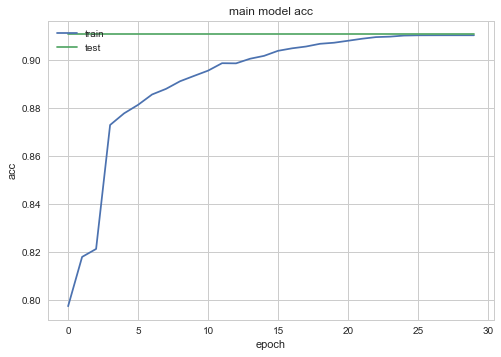

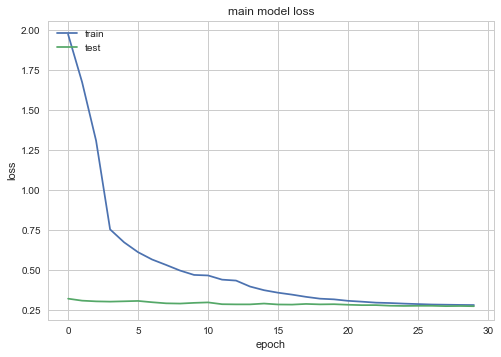

In [30]:
# summarize history for accuracy
plt.plot(history.history['main_output_acc'])
plt.plot(history.history['val_main_output_acc'])
plt.title('main model acc')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['main_output_loss'])
plt.plot(history.history['val_main_output_loss'])
plt.title('main model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

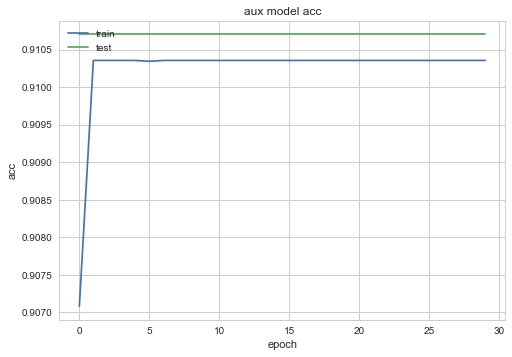

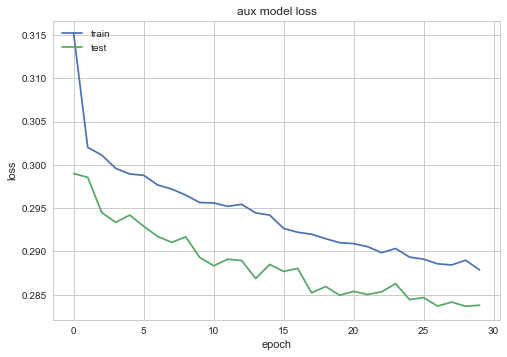

In [31]:
# summarize history for accuracy
plt.plot(history.history['aux_output_acc'])
plt.plot(history.history['val_aux_output_acc'])
plt.title('aux model acc')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['aux_output_loss'])
plt.plot(history.history['val_aux_output_loss'])
plt.title('aux model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [32]:
model.load_weights('lstm.hdf5')
score = model.evaluate({'main_input': X_test_time, 'aux_input': X_test_aux},
          {'main_output': y_test, 'aux_output': y_test},verbose=0)
# loss and the accuracy.
print(score)

[0.42073906556483609, 0.27739576336395494, 0.28668660750067043, 0.90921545346606991, 0.085843370954340831, 0.90921545346606991, 0.08344433604527722]


In [33]:
y_score = model.predict({'main_input': X_test_time, 'aux_input': X_test_aux})
y_pred = y_score

In [34]:
from sklearn.metrics import roc_curve, auc
from sklearn import metrics
def compute_roc(y_test,y_score,method):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    n_classes = 2
    fpr, tpr, _ = metrics.roc_curve(y_test.ravel(), y_score.ravel())
    # Compute micro-average ROC curve and ROC area
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, label=method+' (AUC = %0.4f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

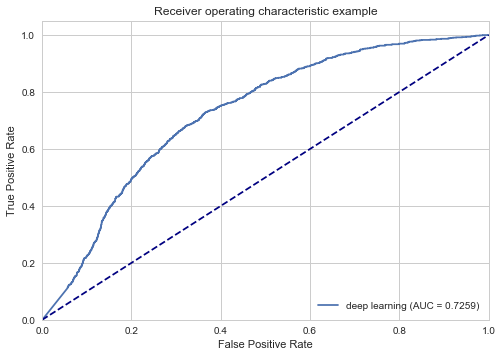

In [35]:
# main auc
compute_roc(y_test,y_score[0],'deep learning')

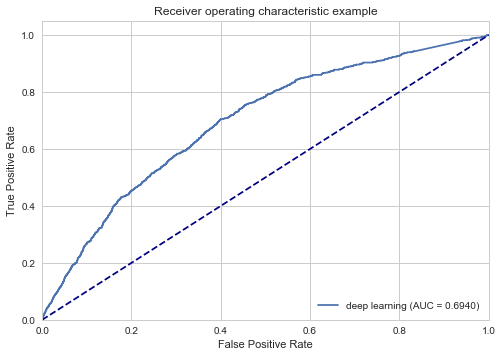

In [36]:
# aux auc
from sklearn.metrics import precision_score
compute_roc(y_test,y_score[1],'deep learning')

In [37]:
precision_score(y_test, (y_pred[0]>0.5).astype(int))

/Users/juan/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


0.0

In [38]:
from sklearn.metrics import recall_score
recall_score(y_test, (y_pred[0]>0.5).astype(int))

0.0

In [39]:
from sklearn.metrics import classification_report
print(classification_report(y_test, (y_pred[0]>0.5).astype(int)))

             precision    recall  f1-score   support

          0       0.91      1.00      0.95      9955
          1       0.00      0.00      0.00       994

avg / total       0.83      0.91      0.87     10949



/Users/juan/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [40]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test, (y_pred[0]>0.5).astype(int)))

[[9955    0]
 [ 994    0]]


In [41]:
from sklearn.metrics import average_precision_score
average_precision_score(y_test, y_score[0])

0.1702847794938529

Average precision-recall score: 0.17


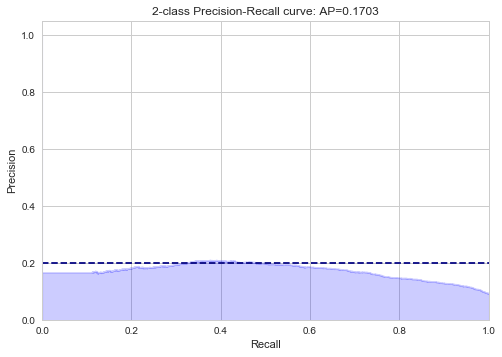

In [42]:
import src.lib.utility_classfier as uclf
uclf.plot_prc(y_test,y_score[0],0.2)